In [5]:
from __future__ import division
import hoomd
import hoomd.md
import numpy
from matplotlib import pyplot

In [6]:
#-----Some important variables

box = 20.0
replicates = 10
np_diameter = 5.0
t_max = 5.0
p_max = 0.5

In [7]:
### -------Define the unit cell

sim = hoomd.context.initialize("");
uc = hoomd.lattice.unitcell(N = 1,
                            a1 = [box, 0, 0],
                            a2 = [0, box, 0],
                            a3 = [0, 0, box],
                            dimensions = 3,
                            position = [[0,0,0]],
                            type_name = ['M'],
                            mass = [1.0],
                            moment_inertia = [[0,
                                               1/12*1.0*8**2,
                                               1/12*1.0*8**2]],
                            orientation = [[1, 0, 0, 0]]);

#-----From the lattice we obtain a snapshot and initialize.

snap = uc.get_snapshot()
snap.replicate(replicates,replicates,replicates)
system = hoomd.init.read_snapshot(snap)

#-----Adding the NP's and it's properties

system.particles.types.add('NP')
np_0 = system.particles[0]
np_1 = system.particles[222]
np_2 = system.particles[444]
np_3 = system.particles[666]

#----- Specify diameter and moment of inertia

np_0.type = 'NP'
np_1.type = 'NP'
np_2.type = 'NP'
np_3.type = 'NP'

np_0.diameter = np_diameter
np_1.diameter = np_diameter
np_2.diameter = np_diameter
np_3.diameter = np_diameter


np_0.moment_inertia = [0,0,0]
np_1.moment_inertia = [0,0,0]
np_2.moment_inertia = [0,0,0]
np_3.moment_inertia = [0,0,0]
#np_4.moment_inertia = [0,0,0]

#-----

#np_0.mass = 5.0
#np_1.mass = 5.0
#np_2.mass = 5.0
#np_3.mass = 5.0
#np_4.mass = 5.0

#-----Add the particle type for the constituent particles.

system.particles.types.add('A');

#-----Define each rigid body type in the local coordinate system of the body.

rigid = hoomd.md.constrain.rigid();
rigid.set_param('M', 
                types=['A']*8,
                positions=[(-4,0,0),(-3,0,0),(-2,0,0),(-1,0,0),
                           (1,0,0),(2,0,0),(3,0,0),(4,0,0)]);

#-----Instruct the rigid constraint to create the constituent particles

rigid.create_bodies();

#-----Define the potential energy

nl = hoomd.md.nlist.cell()

lj = hoomd.md.pair.lj(r_cut = 3.5, nlist=nl)
lj.set_params(mode='shift')

#-----Define interaction with species in the binary mixture

lj.pair_coeff.set('NP','NP', epsilon = 1.0, sigma = 5.0)
lj.pair_coeff.set('M','M', epsilon = 1.0, sigma = 1.0)
lj.pair_coeff.set('A','A', epsilon = 1.0, sigma = 1.0)
lj.pair_coeff.set('M','A', epsilon = 1.0, sigma = 1.0)

lj.pair_coeff.set('NP','M', epsilon = 1.0, sigma = 3.0)
lj.pair_coeff.set('NP','A', epsilon = 1.0, sigma = 3.0)

#-----Select an standard integrator

hoomd.md.integrate.mode_standard(dt=0.005);

#------Define two groups and make their union.

nanoparticles = hoomd.group.type(name='Nano_Particles', type='NP')
mesogens = hoomd.group.rigid_center();
groupNP_mes = hoomd.group.union(name = "NP_Mes", a = nanoparticles, b = mesogens)

#----Integrate using NPT

pressure = hoomd.variant.linear_interp(points = [(0,0.000001), (1e4, p_max)])
temperature = hoomd.variant.linear_interp(points = [(0,1.0), (1e4, t_max)])
npt = hoomd.md.integrate.npt(group = groupNP_mes, kT = temperature, tau = 0.5, tauP = 1.0, P = pressure);
npt.randomize_velocities(seed=42)


hoomd.dump.gsd("binary_mixture.gsd",
               period=1e3,
               group=hoomd.group.all(),
               overwrite=True);  

#-----Write output

log1 = hoomd.analyze.log(filename="binary_mixture.log",
                         quantities=['num_particles',
                                     'ndof',
                                     'translational_ndof',
                                     'rotational_ndof',
                                     'potential_energy',
                                     'kinetic_energy',
                                     'translational_kinetic_energy',
                                     'rotational_kinetic_energy',
                                     'temperature',
                                     'pressure'],
                         period=1e3,
                         overwrite=True);

notice(2): Group "all" created containing 1000 particles
notice(2): constrain.rigid(): Creating 996 rigid bodies (adding 7968 particles)
notice(2): Group "Nano_Particles" created containing 4 particles
notice(2): Group "rigid_center" created containing 996 particles
notice(2): Group "NP_Mes" created containing 1000 particles


In [8]:
with sim:
    hoomd.run(1e5)

notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 8968
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: yes
** starting run **
Time 00:00:10 | Step 550 / 100000 | TPS 54.1005 | ETA 00:30:38
Time 00:00:20 | Step 801 / 100000 | TPS 25.0167 | ETA 01:06:05
Time 00:00:30 | Step 1038 / 100000 | TPS 23.5524 | ETA 01:10:01
Time 00:00:40 | Step 1232 / 100000 | TPS 19.2112 | ETA 01:25:41
Time 00:00:50 | Step 1430 / 100000 | TPS 19.6882 | ETA 01:23:26
Time 00:01:00 | Step 1640 / 100000 | TPS 20.9497 | ETA 01:18:15
Time 00:01:10 | Step 1833 / 100000 | TPS 19.0871 | ETA 01:25:43
Time 00:01:20 | Step 2016 / 100000 | TPS 18.29 | ETA 01:29:17
Time 00:01:30 | Step 2201 / 100000 | TPS 18.3568 | ETA 01:28:47
Time 00:01:41 | Step 2393 / 100000 | TPS 19.0298 | ETA 01:25:29
Time 00:01:51 | Step 2580 / 100000 | TPS 18.4567 | ETA 01:27:58
Time 00:02:01 | Step 2760 / 100000 | TPS 17.956 | ETA 01:

# Orientation analysis

In [9]:
import gsd
import gsd.hoomd

In [10]:
# To show orientations, we use arrows rotated by the quaternions.
from mpl_toolkits.mplot3d.axes3d import Axes3D

# These functions are adapted from the rowan quaternion library.
# See rowan.readthedocs.io for more information.
def quat_multiply(qi, qj):
    """Multiply two sets of quaternions."""
    output = numpy.empty(numpy.broadcast(qi, qj).shape)

    output[..., 0] = qi[..., 0] * qj[..., 0] - \
        numpy.sum(qi[..., 1:] * qj[..., 1:], axis=-1)
    output[..., 1:] = (qi[..., 0, numpy.newaxis] * qj[..., 1:] +
                       qj[..., 0, numpy.newaxis] * qi[..., 1:] +
                       numpy.cross(qi[..., 1:], qj[..., 1:]))
    return output

def quat_rotate(q, v):
    """Rotate a vector by a quaternion."""
    v = numpy.array([0, *v])
    
    q_conj = q.copy()
    q_conj[..., 1:] *= -1
    
    return quat_multiply(q, quat_multiply(v, q_conj))[..., 1:]

In [11]:
t1 = gsd.hoomd.open('binary_mixture.gsd', 'rb')

In [12]:
def orientationPlot(step, t):
    L = t[0].particles.N
    positions = t[step].particles.position[0:L];
    
    orientations = t[step].particles.orientation[0:L]
    arrowheads = quat_rotate(orientations, numpy.array([1, 0, 0]))

    fig = pyplot.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.quiver3D(positions[:, 0], positions[:, 1], positions[:, 2],
                arrowheads[:, 0], arrowheads[:, 1], arrowheads[:, 2])
    ax.set_title("Orientations", fontsize=16);

In [13]:
def nematicOrderTensor(step, t):
 
    L = t[0].particles.N
    quaternions = t[step].particles.orientation[0:L]
    arrowheads = quat_rotate(quaternions, numpy.array([1, 0, 0]))
    
    
    results = []
    for i in range(5):
        results.append( numpy.outer(arrowheads[i],arrowheads[i])  )
        
    Q = numpy.mean(results, axis=0)  # calculate mean without flattening array
    Q -= numpy.identity(3)/3.0       # subtract Identity/3
    
    return(Q)

In [14]:
nematicOrderTensor(0,t1)

array([[ 0.66666667,  0.        ,  0.        ],
       [ 0.        , -0.33333333,  0.        ],
       [ 0.        ,  0.        , -0.33333333]])

In [15]:
def nematization(step, t):
        Q = nematicOrderTensor(step,t)
        
        eigen_values, eigen_vectors = numpy.linalg.eig(Q)
        idx = eigen_values.argsort()[::-1]   
        
        eigen_values = eigen_values[idx]
       
        return(1.5*eigen_values[0])

In [16]:
nematization(9,t1)

0.9690785035312002

In [17]:
def sList(t):

    s = []
    for i in range(len(t)):
        s.append(nematization(i,t))
        
    return(s)

(0, 1.1)

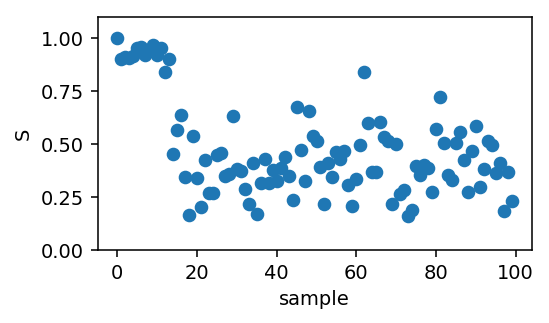

In [18]:
pyplot.figure(figsize=(4,2.2), dpi=140);

s1= sList(t1)

pyplot.scatter(
    numpy.arange(len(s1)), 
    s1);

pyplot.xlabel('sample');
pyplot.ylabel('S');
pyplot.ylim((0,1.1))

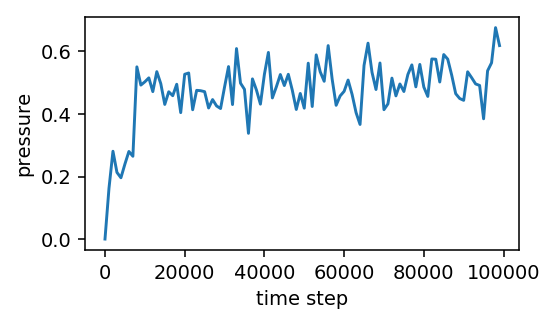

In [19]:
data1 = numpy.genfromtxt(fname='binary_mixture.log', skip_header=True);
pyplot.figure(figsize=(4,2.2), dpi=140);
pyplot.plot(data1[:,0], data1[:,10]);
pyplot.xlabel('time step');
pyplot.ylabel('pressure');

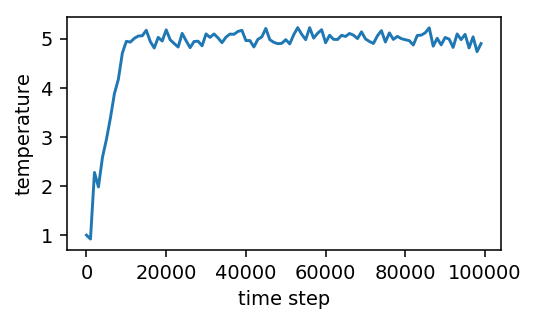

In [20]:
pyplot.figure(figsize=(4,2.2), dpi=140);
pyplot.plot(data1[:,0], data1[:,9]);
pyplot.xlabel('time step');
pyplot.ylabel('temperature');